In [1]:
import torch
from functools import partial


# SGD

## use SGD to estimate quadratic equation

We are trying to estimate a quadratic equation. To do so, we initialize random parameters of the equation. We use mean square error as loss function to calculate the gradient. Then we use SGD to optimize the parameters.

In [2]:
# mean square error
def mse(preds, acts):
    return ((preds - acts) ** 2).mean()


def quad(a, b, c, x):
    return a * x**2 + b * x + x


def mk_quad(a, b, c):
    return partial(quad, a, b, c)


# target model
f = mk_quad(2, 3, 4)
f(2)

# assume some data points
x = torch.linspace(-2, 2, 20)[:, None]
torch.manual_seed(42)

# Generate a tensor of random numbers with the same shape as f(x)
# torch.rand_like(f(x)) generates random numbers between 0 and 1
# with the same shape as f(x). We scale and shift it to the desired range.
random_numbers = torch.rand_like(f(x)) * 10 - 5

# dataset
y = f(x) + random_numbers


# loss function
def quad_mse(params):
    f = mk_quad(*params)
    return mse(f(x), y)


# initial params
params = torch.tensor([4, 5.0, 7.0])
params.requires_grad_()

loss = quad_mse(params)
loss

loss.backward()
params.grad

tensor([11.2822,  6.9424,  0.0000])

Let's calculate the the SGD and loss manually. 

Here is the loss function:
$$
\text{mse}(f(x), y) = \frac{1}{n} \sum_{i=1}^n (f(x_i) - y_i)^2
$$

where $n$ is the number of data points.

To calculate the gradient of the loss, we start with a generic expression

$$
f(x_i) = a x_i^2 + b x_i + c
$$

then

$$
\frac{\partial f(x_i)}{\partial a}
= x_i^2.
$$

Then we have the loss function, where $y_i$ are $y$ value in $(x_i, y_i)$ in the training data and $f(x_i)$ is the target $y$ value

$$
L = \frac{1}{n} \sum_{i=1}^n (f(x_i) - y_i)^2.
$$

So for parameter $a$, our gradient is:

$$
\frac{\partial L}{\partial a}
= \frac{2}{n} \sum_{i=1}^n (f(x_i) - y_i) \cdot x_i^2.
$$

The process is similar for $b$ and $c$.

To perform SGD, we subtract $grad \times learning rate$ from the weight:

$params \mathrel{-}= learning\,rate \times grad$


In [3]:
print("target params", f)
print("initial params", params)
print("initial values of x: ", x[:2])

target params functools.partial(<function quad at 0x7ffac72baf20>, 2, 3, 4)
initial params tensor([4., 5., 7.], requires_grad=True)
initial values of x:  tensor([[-2.0000],
        [-1.7895]])


In [4]:
lr = 0.23
params = torch.tensor([4, 5.0, 7.0])
params.requires_grad_()
for _ in range(10):
    loss = quad_mse(params)
    print("loss ", loss.item())
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None

loss  23.300430297851562
loss  12.930697441101074
loss  10.261430740356445
loss  8.984521865844727
loss  8.224483489990234
loss  7.7517900466918945
loss  7.455584526062012
loss  7.269739627838135
loss  7.153112888336182
loss  7.079920768737793


In [5]:
params

tensor([2.6931, 2.6446, 7.0000], requires_grad=True)

## Use SGD to train image classification on the MNIST dataset

### dataset exploration

In [6]:
#!wget "https://s3.amazonaws.com/fast-ai-sample/mnist_tiny.tgz" -O "data/mnist_tiny.tar.gz" && tar -xzf "data/mnist_tiny.tar.gz" -C data/

In [7]:
from pathlib import Path

path = Path("data/mnist_tiny/")
print(list(path.iterdir()))
threes = sorted((path / "train" / "3").iterdir())
sevens = sorted((path / "train" / "7").iterdir())
threes[1]

[PosixPath('data/mnist_tiny/labels.csv'), PosixPath('data/mnist_tiny/test'), PosixPath('data/mnist_tiny/valid'), PosixPath('data/mnist_tiny/train'), PosixPath('data/mnist_tiny/models')]


PosixPath('data/mnist_tiny/train/3/7030.png')

In [8]:
from PIL import Image

im3_path = threes[2]
im3 = Image.open(im3_path)
im3

In [9]:
from numpy import array

im3_array = array(im3)
im3_array[15:25, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [ 16,  42,   0,   0,   0,   0],
       [197, 102,   0,   0,   0,   0],
       [254, 166,   5,   0,   0,   0],
       [212, 254, 193,  77,  30,   0],
       [ 29, 194, 254, 254, 242, 213],
       [  0,  20, 165, 254, 254, 254],
       [  0,   0,   3,  12,  65, 149],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0]], dtype=uint8)

In [10]:
import torch

im3_t = torch.as_tensor(im3_array)
im3_t[15:25, 4:10]


tensor([[  0,   0,   0,   0,   0,   0],
        [ 16,  42,   0,   0,   0,   0],
        [197, 102,   0,   0,   0,   0],
        [254, 166,   5,   0,   0,   0],
        [212, 254, 193,  77,  30,   0],
        [ 29, 194, 254, 254, 242, 213],
        [  0,  20, 165, 254, 254, 254],
        [  0,   0,   3,  12,  65, 149],
        [  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0]], dtype=torch.uint8)

In [11]:
import pandas as pd

df = pd.DataFrame(im3_t)
df.style.set_properties(**{"font-size": "6pt"}).background_gradient("Greys")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,11,130,224,255,254,244,95,2,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,3,128,243,254,239,229,231,254,254,103,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,92,254,254,212,52,0,5,107,254,223,11,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,28,212,196,54,0,0,0,16,229,254,24,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,16,5,0,0,0,0,0,206,254,24,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,250,254,24,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,166,254,215,9,0,0,0,0,0,0,0


### Prediction using averages
First, we use the most simple classification method, we calculate an "ideal" images of 3s and 7s with averages, then we use a loss function to calculate test images' distance with the 3 and 8, and classify the image based on the lower loss score.

In [12]:
# convert images to tensors arrays
seven_tensors = [torch.as_tensor(array(Image.open(o))) for o in sevens]
three_tensors = [torch.as_tensor(array(Image.open(o))) for o in threes]

# convert tensor array to individual tensors
stacked_sevens = torch.stack(seven_tensors).float() / 255
stacked_threes = torch.stack(three_tensors).float() / 255
stacked_threes.shape


torch.Size([346, 28, 28])

we will create our ideal 3 and 7

In [13]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)

In [14]:
import torchvision.transforms as T


def tensor_image(t):
    return T.ToPILImage()((t * 255).byte())


# Convert tensor to PIL Image (scale values to 0-255 and convert to uint8)
mean3_pil = tensor_image(mean3)
mean3_pil

let's pick a test image

In [15]:
sample = stacked_threes[32]
tensor_image(sample)

we will calculate mean absolute error (L1 norm) the mean square error (L2 norm)

In [16]:
dist_3_abs = (sample - mean3).abs().mean()
dist_3_sqr = ((sample - mean3) ** 2).mean().sqrt()
dist_3_abs, dist_3_sqr


(tensor(0.1350), tensor(0.2499))

In [17]:
dist_7_abs = (sample - mean7).abs().mean()
dist_7_sqr = ((sample - mean7) ** 2).mean().sqrt()
dist_7_abs, dist_7_sqr


(tensor(0.1233), tensor(0.2432))

In [18]:
# use built in loss functions
(
    torch.nn.functional.l1_loss(sample.float(), mean3),
    torch.nn.functional.mse_loss(sample, mean3),
)

(tensor(0.1350), tensor(0.0625))

In [19]:
print("Is the sample a 3? ", dist_3_sqr > dist_7_sqr)

Is the sample a 3?  tensor(True)


Next, we will will apply our classification on the validation set

In [20]:
valid_threes = sorted((path / "valid" / "3").iterdir())
valid_sevens = sorted((path / "valid" / "7").iterdir())
valid_seven_tensors = [torch.as_tensor(array(Image.open(o))) for o in valid_sevens]
valid_three_tensors = [torch.as_tensor(array(Image.open(o))) for o in valid_threes]

# convert tensor array to individual tensors
valid_sevens_stacked = torch.stack(valid_seven_tensors).float() / 255
valid_three_stacked = torch.stack(valid_three_tensors).float() / 255


In [21]:
valid_three_stacked.shape, valid_sevens_stacked.shape

(torch.Size([346, 28, 28]), torch.Size([353, 28, 28]))

Define our loss function with l1 loss

In [22]:
# loss function
def mnist_l1_loss(a, b):
    return (a - b).abs().mean((-1, -2))


mnist_l1_loss(sample, mean3)

tensor(0.1350)

In [23]:
valid_three_distance = mnist_l1_loss(valid_three_stacked, mean3)

valid_three_distance.shape

torch.Size([346])

In [24]:
# leverage broadcast to calculate the distance between samples and the idea 3
(valid_three_stacked - mean3).shape

torch.Size([346, 28, 28])

classify each sample in the validation set, calculate the accuracy

In [25]:
def is_3(x):
    return mnist_l1_loss(x, mean3) < mnist_l1_loss(x, mean7)


accuracy_3s = is_3(valid_three_stacked).float().mean()
accuracy_7s = (1 - is_3(valid_sevens_stacked).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s) / 2


(tensor(0.9335), tensor(0.9972), tensor(0.9653))

we can see that the accuracy is very high in both cases.

### Train a linear model for classification

Prepare the training data

In [26]:
# concat all images into a tensor, flatten each image into an array
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28 * 28)
train_x.shape, stacked_threes.shape, stacked_sevens.shape

(torch.Size([709, 784]), torch.Size([346, 28, 28]), torch.Size([363, 28, 28]))

We will create labels, where 1s are three and 0s are seven.

In [27]:
train_y = torch.tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)
train_y.shape


torch.Size([709, 1])

we need to put x and y together into `(x,y)` tuples

In [28]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

Prepare the validation set

In [29]:
valid_x = torch.cat([valid_three_stacked, valid_sevens_stacked]).view(-1, 28 * 28)
valid_y = torch.tensor(
    [1] * len(valid_three_stacked) + [0] * len(valid_sevens_stacked)
).unsqueeze(1)
# zip them together
valid_dset = list(zip(valid_x, valid_y))

initialize weights

In [30]:
def init_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()


weights = init_params((28 * 28, 1))
bias = init_params(1)

calculate the prediction

In [31]:
(train_x[0] * weights.T).sum() + bias


tensor([10.6083], grad_fn=<AddBackward0>)

instead of use for-loop, we use matrix multiplication, `@` in pytorch

In [32]:
def linear1(xb):
    return xb @ weights + bias


preds = linear1(train_x)

predictions are correct when they are the same with the labels, if the prediction is greater than 0, then it is three, otherwise 1

In [33]:
corrects = (preds > 0.0).float() == train_y
corrects.float().mean().item()

0.4668547213077545

We need a loss function now to perform SGD, but accuracy can't serve as a loss function, because small change in weights is insignificant to change the results of accuracy.

In [34]:
with torch.no_grad():
    weights[0] *= 1.01


preds = linear1(train_x)
((preds > 0.0).float() == train_y).float().mean().item()


0.4668547213077545

how `torch.where` work?

In [35]:
trgts = torch.tensor([1, 0, 1, 1])
prds = torch.tensor([0.9, 0.4, 0.2, 1])
torch.where(trgts == 1, 1 - prds, prds)

tensor([0.1000, 0.4000, 0.8000, 0.0000])

we define a loss function as the distance between prediction and the true values with `where`

In [36]:
def mnist_loss_v1(predictions, targets):
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

we use sigmoid to restrict input to the loss function to 0 and 1

In [37]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))


def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()


we use `DataLoader` to handle shuffling between episodes when training in batches

In [38]:
from torch.utils.data import DataLoader

coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)


[tensor([ 1,  5,  8,  2, 13]),
 tensor([ 6, 10, 14,  4,  3]),
 tensor([ 7,  9, 11,  0, 12])]

However, an collection like above is not enough, we need both independent and dependent vars (training data and target values), which is similar to this:

In [39]:
import string

ds = list(enumerate(string.ascii_lowercase))
dl = DataLoader(ds, batch_size=6, shuffle=True)
ds[:3], list(dl)

([(0, 'a'), (1, 'b'), (2, 'c')],
 [[tensor([10,  5, 19, 18,  2, 25]), ('k', 'f', 't', 's', 'c', 'z')],
  [tensor([14,  7,  3,  4,  6, 17]), ('o', 'h', 'd', 'e', 'g', 'r')],
  [tensor([13, 22, 24,  8, 20,  9]), ('n', 'w', 'y', 'i', 'u', 'j')],
  [tensor([23, 11,  0, 12, 21, 15]), ('x', 'l', 'a', 'm', 'v', 'p')],
  [tensor([16,  1]), ('q', 'b')]])

Now we will implement SGD, our algorithm will look like this:
```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

In [40]:
weights = init_params((28 * 28, 1))
bias = init_params(1)


dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)
xb, yb = next(iter(dl))
xb.shape, yb.shape


(torch.Size([256, 784]), torch.Size([256, 1]))

at a basic level, we implement SGD as such

In [41]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()


notice how the gradients have changed as a result of SGD

In [42]:
batch = train_x[:4]
calc_grad(batch, train_y[:4], linear1)
print(weights.grad.mean(), bias.grad)
calc_grad(batch, train_y[:4], linear1)
print(weights.grad.mean(), bias.grad)

tensor(-0.0187) tensor([-0.1239])
tensor(-0.0374) tensor([-0.2478])


Put it all together

In [43]:
# train all samples in the dataloader
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()


# calculate accuracy in a batch
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()


# calculate accuracy for all batches in the validation dataloader
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)


In [44]:
validate_epoch(linear1)

0.28

As shown above, our starting point accuracy is `validate_epoch(linear1)`. We will train 1 epoch.

In [45]:
lr = 0.3
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.3951

The accuracy has improved. We will train for another 20 epochs.

In [46]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=" ")


0.4107 0.4172 0.425 0.4355 0.4472 0.4472 0.4589 0.4646 0.4698 0.4786 0.4821 0.4906 0.4977 0.5126 0.5337 0.5664 0.6048 0.673 0.7423 0.7887 

Next, we will create an optimizer that handles SGD

In [47]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr

    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

use `nn.Linear` to create a linear function that has helper function to extract parameters

In [48]:
linear_model = torch.nn.Linear(28 * 28, 1)
opt = BasicOptim(linear_model.parameters(), lr)

rewrite the training loop with the optimizer

In [49]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()


def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=" ")


train_model(linear_model, 20)

0.8543 0.8529 0.9574 0.9717 0.9756 0.9756 0.9751 0.9751 0.9777 0.9777 0.9777 0.979 0.979 0.979 0.979 0.979 0.979 0.9803 0.9803 0.9816 

### Train an NN for classification

Now we are in a position to introduce neural network with non-linearity with a `max` function

In [50]:
w1 = init_params((28 * 28, 30))
b1 = init_params(30)
w2 = init_params((30, 1))
b2 = init_params(1)


def simple_net(xb):
    res = xb @ w1 + b1
    res = res.max(torch.tensor(0.0))
    res = res @ w2 + b2
    return res


In [51]:
import matplotlib.pyplot as plt


def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6, 4)):
    x = torch.linspace(min, max, 100)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x, f(x))
    if tx is not None:
        ax.set_xlabel(tx)
    if ty is not None:
        ax.set_ylabel(ty)
    if title is not None:
        ax.set_title(title)


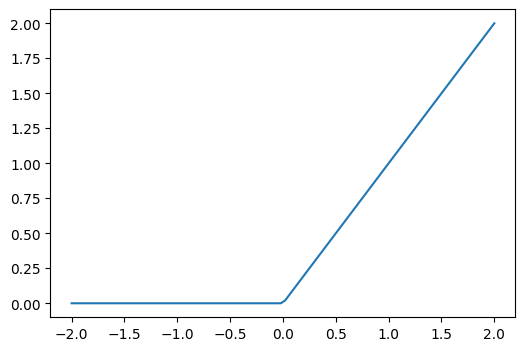

In [52]:
plot_function(torch.nn.functional.relu)

In [53]:
neural_net_example = torch.nn.Sequential(
    torch.nn.Linear(28 * 28, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1)
)

opt = BasicOptim(neural_net_example.parameters(), lr=0.1)


train_model(neural_net_example, 20)


0.599 0.7904 0.888 0.9375 0.9552 0.9644 0.9709 0.9717 0.9704 0.9743 0.9743 0.9743 0.9756 0.9756 0.9769 0.9769 0.9795 0.9795 0.9795 0.9795 

# Collaborative Filtering